In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
from torchvision import datasets, models, transforms
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
import tensorflow_hub as hub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
!pip install tensorflow-addons
from tensorflow_addons.optimizers import AdamW

In [3]:
import pathlib

In [4]:

from google.colab import drive
drive.mount('/content/gdrive/') # измени содержимое
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip # измени содержимое



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
batch_size = 10
img_height = 224 
img_width = 224

In [6]:
data_dir = pathlib.Path('/content/gdrive/MyDrive/raw_material/') # загрузка датасета , должна быть папка с папками, эти папки с именем названия классов, в папках картинки

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

Found 428 files belonging to 2 classes.
Using 343 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
 )

Found 428 files belonging to 2 classes.
Using 85 files for validation.


In [9]:
class_names = train_ds.class_names
#print(class_names)

['High_quality_raw_materials', 'Low_quality_raw_materials']


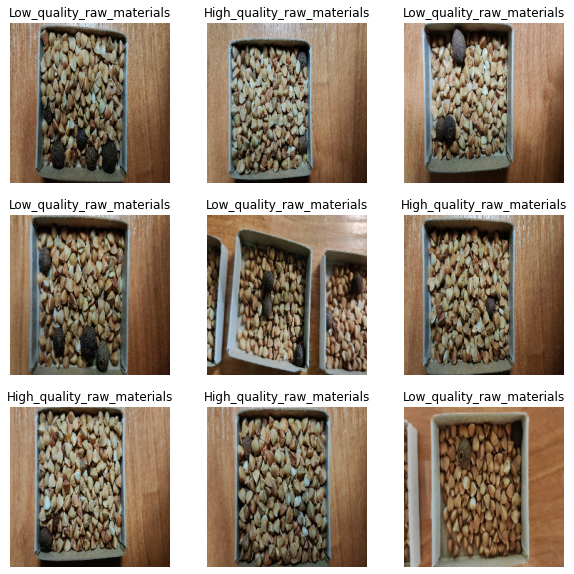

In [10]:
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
'''

In [11]:
'''
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
'''

(10, 224, 224, 3)
(10,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

-----


In [13]:

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.05),
    layers.experimental.preprocessing.RandomZoom(0.05),
    #layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="constant")
  ]
)


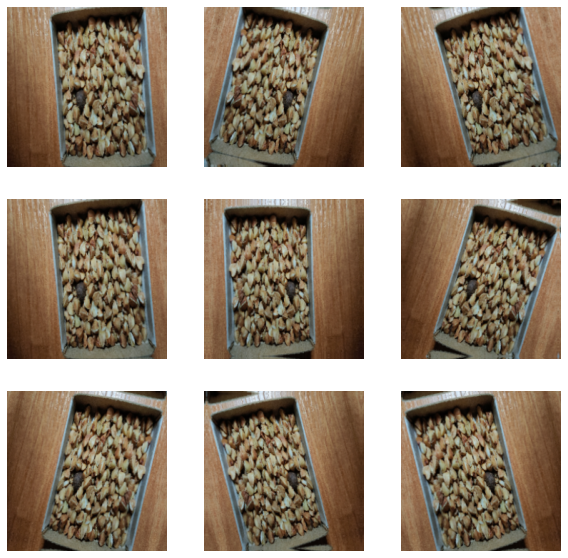

In [14]:
'''
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
  '''

In [15]:
num_classes = 2

Модель:


In [18]:


model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])


In [20]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#, f1_score])


In [21]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)     

In [22]:
epochs = 100 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
35/35 [==============================] - 27s 591ms/step - loss: 3.1241 - accuracy: 0.5481 - val_loss: 0.6930 - val_accuracy: 0.4824
Epoch 2/100
35/35 [==============================] - 1s 33ms/step - loss: 0.6515 - accuracy: 0.6385 - val_loss: 0.6901 - val_accuracy: 0.6235
Epoch 3/100
35/35 [==============================] - 1s 33ms/step - loss: 0.5929 - accuracy: 0.6997 - val_loss: 0.6809 - val_accuracy: 0.5529
Epoch 4/100
35/35 [==============================] - 1s 33ms/step - loss: 0.5309 - accuracy: 0.7580 - val_loss: 0.6594 - val_accuracy: 0.8235
Epoch 5/100
35/35 [==============================] - 1s 32ms/step - loss: 0.4544 - accuracy: 0.7930 - val_loss: 0.6349 - val_accuracy: 0.7529
Epoch 6/100
35/35 [==============================] - 1s 33ms/step - loss: 0.3984 - accuracy: 0.8367 - val_loss: 0.5999 - val_accuracy: 0.7176
Epoch 7/100
35/35 [==============================] - 1s 33ms/step - loss: 0.3119 - accuracy: 0.8717 - val_loss: 0.5602 - val_accuracy: 0.7647
Epoc

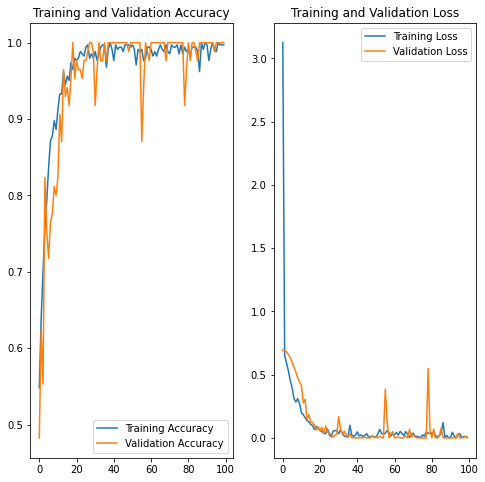

In [25]:
'''
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
'''

In [36]:
model.save_weights('my_model.h5', save_format='h5')

In [40]:
from google.colab import files 

files.download('/content/my_model.h5') #выгрузка файла

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>